# Pitch Detection

Writing my own algorithm for pitch detection.

Idea:
1. Preprocess (remove noise outside violin frequency range)
2. FFT / autocorrelation
3. Profit

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import scipy.signal as signal
import scipy.fftpack as fftpack
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal.windows import kaiser
from scipy.signal import correlate, decimate
from numpy.fft import rfft

# Your existing pitch detection methods
def freq_from_fft(signal, fs):
    N = len(signal)
    windowed = signal * kaiser(N, 100)
    f = rfft(windowed)
    i_peak = np.argmax(np.abs(f))
    return fs * i_peak / N

def freq_from_autocorr(signal, fs):
    signal -= np.mean(signal)
    corr = correlate(signal, signal, mode='full')
    corr = corr[len(corr)//2:]
    d = np.diff(corr)
    start = np.where(d > 0)[0][0]
    i_peak = np.argmax(corr[start:]) + start
    return fs / i_peak

def freq_from_hps(signal, fs):
    N = len(signal)
    signal -= np.mean(signal)
    windowed = signal * kaiser(N, 100)
    X = np.log(np.abs(rfft(windowed)))
    X -= np.mean(X)
    hps = np.copy(X)
    for h in range(2, 9):
        dec = decimate(X, h, zero_phase=True)
        hps[:len(dec)] += dec
    i_peak = np.argmax(hps[:len(dec)])
    return fs * i_peak / N

# Step 1: Load your audio file
audio_path = 'data/audio_files/user_fugue2.mp3'  # Replace with your file path
y, sr = librosa.load(audio_path, sr=None)

# Step 2: Process the audio in chunks
frame_size = 2048  # You can adjust this
hop_size = 1024  # Overlap between frames
num_frames = (len(y) - frame_size) // hop_size

# Store results
times = []
pitches_fft = []
pitches_autocorr = []
pitches_hps = []

for i in range(num_frames):
    start = i * hop_size
    end = start + frame_size
    frame = y[start:end]

    time = start / sr
    pitch_fft = freq_from_fft(frame, sr)
    pitch_autocorr = freq_from_autocorr(frame, sr)
    pitch_hps = freq_from_hps(frame, sr)

    times.append(time)
    pitches_fft.append(pitch_fft)
    pitches_autocorr.append(pitch_autocorr)
    pitches_hps.append(pitch_hps)


In [10]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt, correlate, decimate
from scipy.signal.windows import kaiser
from numpy.fft import rfft

# Define violin frequency range
MIN_VIOLIN_FREQ = 196  # Hz
MAX_VIOLIN_FREQ = 5000  # Hz

# Preprocessing: Band-pass filter
def bandpass_filter(signal, sample_rate, lowcut=MIN_VIOLIN_FREQ, highcut=MAX_VIOLIN_FREQ, order=5):
    """
    Apply a band-pass filter to the signal to keep only frequencies within the violin range.
    
    Parameters:
    - signal: numpy array of audio samples
    - sample_rate: the sampling rate of the audio
    - lowcut: the lower cutoff frequency
    - highcut: the upper cutoff frequency
    
    Returns:
    - filtered_signal: the band-pass filtered audio
    """
    sos = butter(order, [lowcut, highcut], btype='band', fs=sample_rate, output='sos')
    filtered_signal = sosfilt(sos, signal)
    return filtered_signal

def freq_from_fft(signal, fs):
    N = len(signal)
    windowed = signal * kaiser(N, 100)
    f = rfft(windowed)
    i_peak = np.argmax(np.abs(f))
    pitch = fs * i_peak / N
    return pitch if MIN_VIOLIN_FREQ <= pitch <= MAX_VIOLIN_FREQ else None

def freq_from_autocorr(signal, fs):
    signal -= np.mean(signal)
    corr = correlate(signal, signal, mode='full')
    corr = corr[len(corr)//2:]
    d = np.diff(corr)
    start = np.where(d > 0)[0][0]
    i_peak = np.argmax(corr[start:]) + start
    pitch = fs / i_peak
    return pitch if MIN_VIOLIN_FREQ <= pitch <= MAX_VIOLIN_FREQ else None

def freq_from_hps(signal, fs):
    N = len(signal)
    signal -= np.mean(signal)
    windowed = signal * kaiser(N, 100)
    X = np.log(np.abs(rfft(windowed)))
    X -= np.mean(X)
    hps = np.copy(X)
    for h in range(2, 9):
        dec = decimate(X, h, zero_phase=True)
        hps[:len(dec)] += dec
    i_peak = np.argmax(hps[:len(dec)])
    pitch = fs * i_peak / N
    return pitch if MIN_VIOLIN_FREQ <= pitch <= MAX_VIOLIN_FREQ else None


In [ ]:
# Step 1: Load your audio file
audio_path = 'data/audio_files/user_fugue2.mp3'  
y, sr = librosa.load(audio_path, sr=None)

# Step 2: Apply band-pass filter
filtered_y = bandpass_filter(y, sr)

# Step 3: Process the audio in chunks
frame_size = 2048  # You can adjust this
hop_size = 1024  # Overlap between frames
num_frames = (len(filtered_y) - frame_size) // hop_size

# Store results
times = []
pitches_fft = []
pitches_autocorr = []
pitches_hps = []

for i in range(num_frames):
    start = i * hop_size
    end = start + frame_size
    frame = filtered_y[start:end]

    time = start / sr
    pitch_fft = freq_from_fft(frame, sr)
    pitch_autocorr = freq_from_autocorr(frame, sr)
    pitch_hps = freq_from_hps(frame, sr)

    times.append(time)
    pitches_fft.append(pitch_fft)
    pitches_autocorr.append(pitch_autocorr)
    pitches_hps.append(pitch_hps)

# Convert lists to numpy arrays
times = np.array(times)
pitches_fft = np.array(pitches_fft)
pitches_autocorr = np.array(pitches_autocorr)
pitches_hps = np.array(pitches_hps)

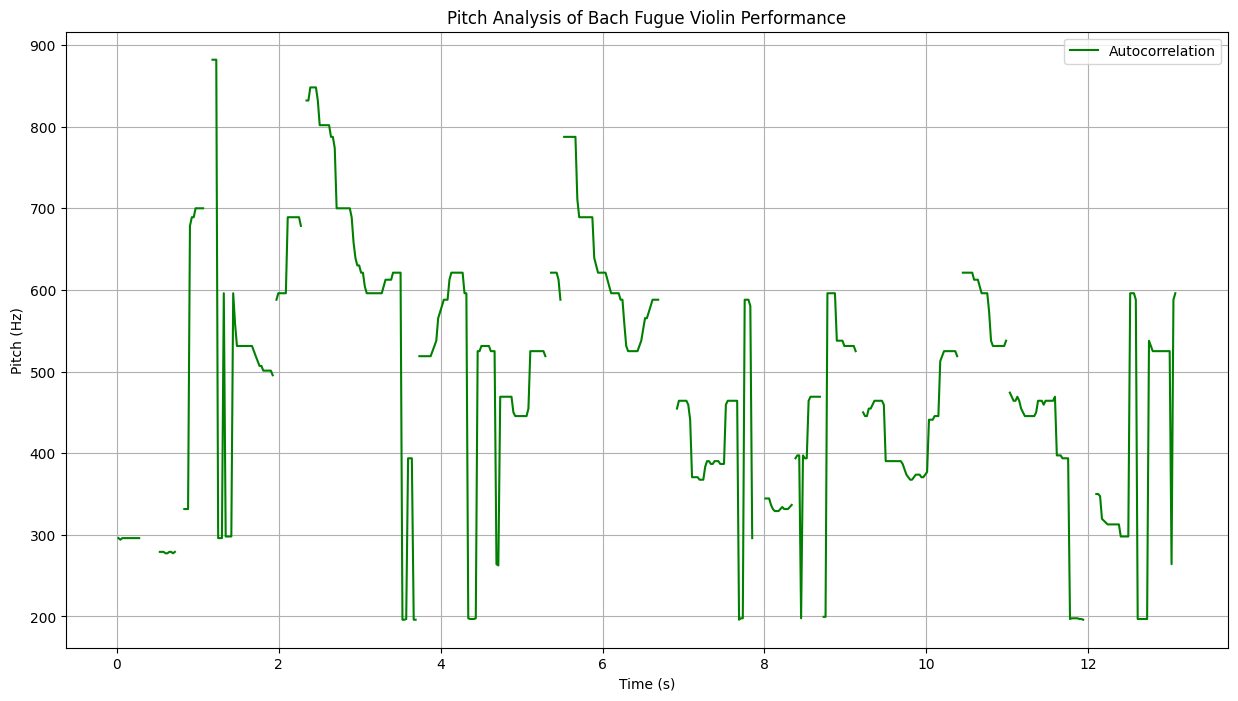

In [11]:
# Step 4: Plot the analyzed pitch over time
plt.figure(figsize=(15, 8))

# plt.plot(times[:len(pitches_fft)], pitches_fft, label='FFT', color='blue')
plt.plot(times[:len(pitches_autocorr)], pitches_autocorr, label='Autocorrelation', color='green')
# plt.plot(times[:len(pitches_hps)], pitches_hps, label='HPS', color='red')

plt.xlabel('Time (s)')
plt.ylabel('Pitch (Hz)')
plt.title('Pitch Analysis of Bach Fugue Violin Performance')
plt.legend()
plt.grid(True)
plt.show()

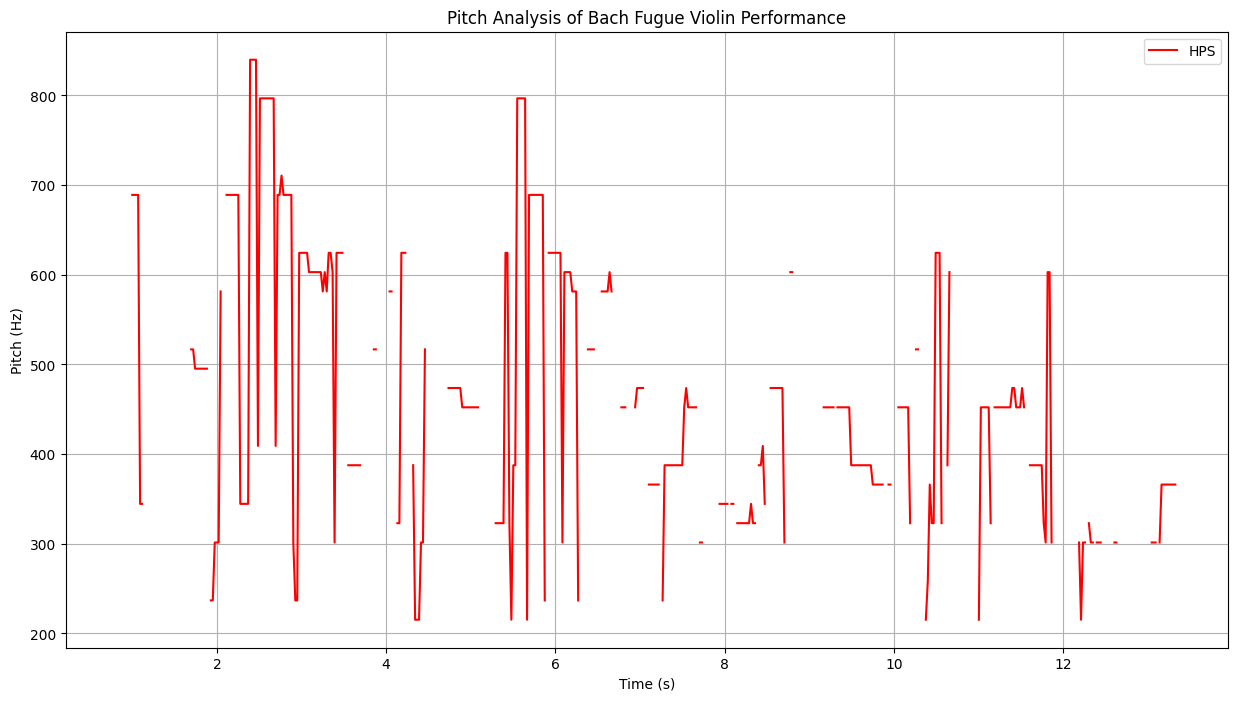

In [13]:
# Step 3: Plot the analyzed pitch over time
plt.figure(figsize=(15, 8))

# plt.plot(times, pitches_fft, label='FFT', color='blue')
# plt.plot(times, pitches_autocorr, label='Autocorrelation', color='green')
plt.plot(times, pitches_hps, label='HPS', color='red')

plt.xlabel('Time (s)')
plt.ylabel('Pitch (Hz)')
plt.title('Pitch Analysis of Bach Fugue Violin Performance')
plt.legend()
plt.grid(True)
plt.show()